In [38]:
import scipy
import fitsio
import smatch
import proplot as pplt
import numpy as np
import hpgeom
import numba
import tqdm

%matplotlib inline

In [395]:
def gen_fake_data(
    *, edata, nside, seed,
    rho_night=0.891,
    zp_mean=0, zp_std=0.0327,
    tel_eff_mean=-1.51e-4, tel_eff_std=5e-6,
    star_mean=0, star_std=0,
    star_nse_mean=0, star_nse_std=0.1,
    sstar_nse_mean=0, sstar_nse_std=2e-3,
    target_nstar=None,
):
    """Generate fake data."""
    rng = np.random.RandomState(seed=seed)
        
    period = 365*3
    night = (edata["mjd_obs"] + 0.5).astype(int)
    night = night - np.min(night) + 100
    year = night // period
    night_in_year = (night % period)/period
    uyear, inv_uyear = np.unique(year, return_inverse=True)
    unight, inv_unight = np.unique(night, return_inverse=True)
    
    true_zp_night = rng.normal(
        loc=zp_mean,
        scale=zp_std,
        size=unight.shape,
    )
        
    true_zp_nse = rng.normal(
        loc=zp_mean,
        scale=zp_std,
        size=edata.shape,
    )
    
    width = np.sqrt(12) * tel_eff_std
    true_tel_eff = rng.uniform(
        low=tel_eff_mean - width/2,
        high=tel_eff_mean + width/2,
        size=uyear.shape,
    ) * 365.0

    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    true_zp = (
        sqrt_rho_night * true_zp_night[inv_unight] 
        + rho_night_fac * true_zp_nse
        + true_tel_eff[inv_uyear] * night_in_year
    )
    
    edmatch = smatch.Matcher(edata["ra"], edata["dec"])    
    star_ra, star_dec = hpgeom.pixel_to_angle(nside, np.arange(hpgeom.nside_to_npixel(nside)))

    _, _, nest_ind, _ = edmatch.query_radius(star_ra, star_dec, 1.0, return_indices=True)
    nest_ind = np.unique(nest_ind)
    
    star_ra = star_ra[nest_ind]
    star_dec = star_dec[nest_ind]
    
    if target_nstar is not None:
        err_fac = np.sqrt(star_ra.shape[0]/target_nstar)
        star_nse_std *= err_fac
        sstar_nse_std *= err_fac

    _, ied, istar, _ = edmatch.query_radius(star_ra, star_dec, 1.0, return_indices=True)

    true_star = rng.normal(
        loc=star_mean,
        scale=star_std,
        size=star_ra.shape,
    )
    
    star_obs = (
        true_star[istar] 
        + true_zp[ied]
        + rng.normal(
            loc=star_nse_mean,
            scale=star_nse_std,
            size=istar.shape,
        )
    )
    star_obs_err = np.ones_like(star_obs) * star_nse_std

    isstar = rng.choice(len(star_ra))
    star_obs = np.concatenate(
        [
            star_obs,
            true_star[isstar] 
            + rng.normal(
                loc=sstar_nse_mean,
                scale=sstar_nse_std,
                size=1,
            ) 
        ],
        axis=0,
    )
    star_obs_err = np.concatenate(
        [
            star_obs_err,
            [sstar_nse_std],
        ],
        axis=0,
    )
    
    return {
        "params": {
            "nside": nside,
            "seed": seed,
            "zp_mean": zp_mean,
            "zp_std": zp_std,
            "star_mean": star_mean, 
            "star_std": star_std,
            "star_nse_mean": star_nse_mean,
            "star_nse_std": star_nse_std,
            "sstar_nse_mean": sstar_nse_mean,
            "sstar_nse_std": sstar_nse_std,
            "rho_night": rho_night,
        },
        "data": {
            "night": night,
            "unight": unight,
            "inv_unight": inv_unight,
            "uyear": uyear,
            "inv_uyear": inv_uyear,
            "night_in_year": night_in_year,
            "true_zp_night": true_zp_night,
            "true_zp_nse": true_zp_nse,
            "true_tel_eff": true_tel_eff,
            "true_zp": true_zp,
            "true_star": true_star,
            "true_star_nest_ind": nest_ind,
            "ied": ied,
            "istar": istar,
            "isstar": isstar,
            "star_ra": star_ra,
            "star_dec": star_dec,
            "star_obs": star_obs,
            "star_obs_err": star_obs_err,
            "rho_night": rho_night,
        }
    }

In [396]:
_ed = fitsio.read("des_exposure_data.fits")

In [397]:
_ed = np.sort(_ed, order="mjd_obs")

In [398]:
_ed.shape

(100802,)

In [603]:
nside = 1024
# nside = 256

fd = gen_fake_data(
    edata=_ed[_ed["band"] == "r"],
    # edata=_ed[(_ed["mjd_obs"] < 57200) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57900) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 57900) & (_ed["band"] == "r")],
    nside=nside,
    seed=10,
    target_nstar=20e6,
)

<a list of 1 Line2D objects>

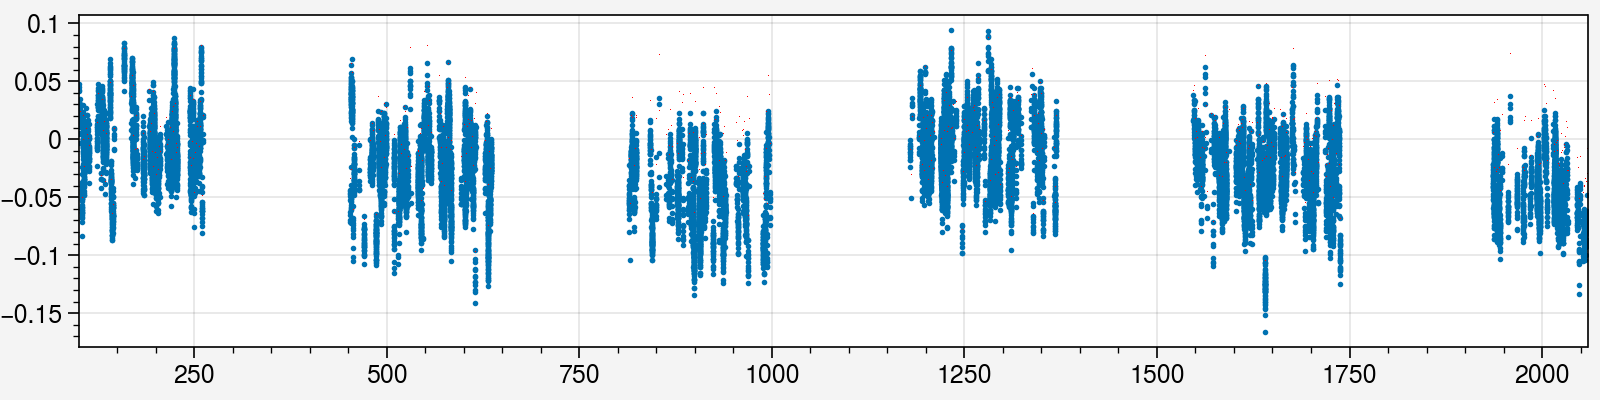

In [604]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")

# axs.format(ylim=(-1.5, 0.2), xlim=(0, 50))

In [605]:
data = fd

kwargs = dict(
    nnight=data["data"]["true_zp_night"].shape[0],
    nexp=data["data"]["true_zp_nse"].shape[0],
    nstar=data["data"]["true_star"].shape[0],
    nyear=data["data"]["true_tel_eff"].shape[0],
    inv_uyear=data["data"]["inv_uyear"],
    night_in_year=data["data"]["night_in_year"],
    inv_unight=data["data"]["inv_unight"], 
    istar=data["data"]["istar"], 
    ied=data["data"]["ied"], 
    isstar=data["data"]["isstar"], 
    star_obs=data["data"]["star_obs"], 
    star_obs_err=data["data"]["star_obs_err"],
    rho_night=data["params"]["rho_night"],
)

In [606]:
def _guess(data, eps):
    nnight = data["data"]["true_zp_night"].shape[0]
    nexp = data["data"]["true_zp_nse"].shape[0]
    nstar = data["data"]["true_star"].shape[0]
    nyear = data["data"]["true_tel_eff"].shape[0]
    nump = nyear + nnight + nexp + nstar 
    g = np.random.normal(scale=eps, size=nump)
    # g[nnight+nexp:] = g[nnight+nexp:] + 1
    g[0:nyear] = -1.5e-4 * (1.0 + g[0:nyear]) * 365
    return g

## Try Numba w/ Custom GD Method

In [607]:
@numba.njit(parallel=True, fastmath=True, nogil=True)
def compute_chi2_and_grad(
    pars, grad, 
    *, nyear, nnight, nexp, nstar, 
    inv_uyear,
    inv_unight, 
    istar, ied, isstar, 
    night_in_year,
    star_obs, star_obs_err,
    rho_night,
):
    npars = pars.shape[0]
    grad[:] = 0.0
    chi2 = 0.0
    nobs = star_obs.shape[0]
    
    tel_eff = pars[0:nyear]
    zp_night = pars[nyear:nyear+nnight]
    zp_exp = pars[nyear+nnight:nyear+nnight+nexp]
    true_star = pars[nyear+nnight+nexp:]

    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    for i in range(nobs-1):
        _istar = istar[i]
        _ied = ied[i]
        _inight = inv_unight[_ied]
        _iyear = inv_uyear[_ied]
        
        pred_zp = (
            sqrt_rho_night * zp_night[_inight] 
            + rho_night_fac * zp_exp[_ied]
            + night_in_year[_ied] * tel_eff[_iyear]
        )
        pred_star = true_star[_istar] + pred_zp
        
        chi = (star_obs[i] - pred_star) / star_obs_err[i]
        chi2 += (chi*chi)
        
        efac = -2.0 * chi / star_obs_err[i] / nobs
        
        grad[_iyear] += efac * night_in_year[_ied]
        grad[nyear + _inight] += efac * sqrt_rho_night
        grad[nyear + nnight + _ied] += efac * rho_night_fac
        grad[nyear + nnight + nexp + _istar] += efac
        
    
    i = nobs-1
    pred_star = true_star[isstar]
    chi = (star_obs[i] - pred_star) / star_obs_err[i]
    chi2 += (chi*chi)
    efac = -2.0 * chi / star_obs_err[i] / nobs
    grad[nyear + nnight + nexp + isstar] += efac
    
    return chi2/nobs, grad

In [615]:
@numba.njit(parallel=True, fastmath=True, nogil=True)
def compute_chi2_and_grad_parallel(
    pars, grad, mygrads,
    *, nyear, nnight, nexp, nstar, 
    inv_uyear,
    inv_unight, 
    istar, ied, isstar, 
    night_in_year,
    star_obs, star_obs_err,
    rho_night,
):
    nt = numba.get_num_threads()
    tid = numba.get_thread_id()
    
    npars = pars.shape[0]
    grad[:] = 0.0
    chi2 = 0.0
    nobs = star_obs.shape[0]
    
    tel_eff = pars[0:nyear]
    zp_night = pars[nyear:nyear+nnight]
    zp_exp = pars[nyear+nnight:nyear+nnight+nexp]
    true_star = pars[nyear+nnight+nexp:]

    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    mygrads[:, :] = 0.0
    
    for i in numba.prange(nobs-1):
        _istar = istar[i]
        _ied = ied[i]
        _inight = inv_unight[_ied]
        _iyear = inv_uyear[_ied]
        
        pred_zp = (
            sqrt_rho_night * zp_night[_inight] 
            + rho_night_fac * zp_exp[_ied]
            + night_in_year[_ied] * tel_eff[_iyear]
        )
        pred_star = true_star[_istar] + pred_zp
        
        chi = (star_obs[i] - pred_star) / star_obs_err[i]
        chi2 += (chi*chi)
        
        efac = -2.0 * chi / star_obs_err[i] / nobs
        
        mygrads[tid, _iyear] += efac * night_in_year[_ied]
        mygrads[tid, nyear + _inight] += efac * sqrt_rho_night
        mygrads[tid, nyear + nnight + _ied] += efac * rho_night_fac
        mygrads[tid, nyear + nnight + nexp + _istar] += efac
        
    for i in range(nt):
        grad += mygrads[i]
        
    i = nobs-1
    pred_star = true_star[isstar]
    chi = (star_obs[i] - pred_star) / star_obs_err[i]
    chi2 += (chi*chi)
    efac = -2.0 * chi / star_obs_err[i] / nobs
    grad[nyear + nnight + nexp + isstar] += efac
    
    return chi2/nobs, grad

In [619]:
nt = numba.get_num_threads()
pars = _guess(fd, 1e-3)
grad = np.zeros_like(pars)
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)
pchi2, pgrad = compute_chi2_and_grad_parallel(pars, grad, tgrads, **kwargs)

In [620]:
chi2, pchi2, np.allclose(grad, pgrad), numba.get_num_threads()

(2.0865361507088585, 2.086536150708638, True, 4)

## check the gradient

In [621]:
# pars = _guess(fd, 1e-3)

In [622]:
# grad = np.zeros_like(pars)
# chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)

# eps = 1e-10
# for ind in tqdm.trange(pars.shape[0]):
#     epars = pars.copy()
#     epars[ind] = epars[ind] + eps
#     egrad = np.zeros_like(pars)
#     echi2, egrad = compute_chi2_and_grad(epars, egrad, **kwargs)
#     if not np.allclose(grad[ind], (echi2 - chi2) / eps, rtol=1e-1, atol=0):
#         print(
#             ind, grad[ind], (echi2 - chi2) / eps
#         )

## use adam / AMSgrad

In [623]:
def _run_agd(
    fun, x, alpha, nsteps, beta1=0.9, beta2=0.99, 
    ostate=None, eps=1e-6, atol=1e-6, rtol=1e-6,
):
    if ostate is None:
        ostate = {}
        ostate["opt"] = dict(
            m=0.0,
            v=0.0,
            max_v=0.0,
            t=0,
            fval_prev=None,
        )
    m = ostate["opt"]["m"]
    v = ostate["opt"]["v"]
    max_v = ostate["opt"]["max_v"]
    tstart = ostate["opt"]["t"]
    fval_prev = ostate["opt"]["fval_prev"]
    nok = 0
    with tqdm.trange(nsteps, ncols=80) as itr:
        for t in itr:
            fval, g = fun(x)
            m = beta1 * m + (1.0 - beta1) * g
            v = beta2 * v + (1.0 - beta2) * g*g
            max_v = np.maximum(max_v, v)
            x -= alpha / np.power(t + tstart + 1, 0.1) * m / np.sqrt(max_v + eps)

            if fval_prev is not None:
                if np.abs(fval - fval_prev) <= (atol + rtol * np.abs(fval_prev)):
                    nok += 1
                    if nok == 100:
                        break
            fval_prev = fval
            
            itr.set_description("chi2/dof = %0.8e" % fval)
        

    ostate["x"] = x
    ostate["opt"] = dict(
        m=m,
        v=v,
        max_v=max_v,
        t=t + tstart,
        fval_prev=fval_prev,
    )
    ostate["fun"] = fval
    return ostate

In [624]:
from functools import partial

nt = numba.get_num_threads()
x0 = _guess(fd, 1e-4)
grad = np.zeros_like(x0)
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

def ofun(pars):
    return compute_chi2_and_grad_parallel(pars, grad, tgrads, **kwargs)

ores = _run_agd(ofun, x0, 0.01, 1000)
# ores = _run_agd(ofun, ores["x"], 0.25, 500)
ores

chi2/dof = 9.18895955e-01:  67%|████████▋    | 668/1000 [05:41<02:49,  1.95it/s]


{'opt': {'m': array([-3.43885230e-04, -3.81778863e-04, -2.14309939e-07, ...,
         -1.35410539e-06,  3.81560547e-07, -1.82582017e-06]),
  'v': array([2.02310219e-04, 1.07216399e-04, 4.45420683e-08, ...,
         2.34962941e-12, 1.68087716e-13, 3.74369097e-12]),
  'max_v': array([1.25816121e-01, 6.31498905e-02, 2.72067008e-05, ...,
         6.16151810e-12, 2.88408278e-13, 5.85255848e-12]),
  't': 668,
  'fval_prev': 0.9188959546972301},
 'x': array([-0.05887203, -0.05382946,  0.04410108, ...,  0.00821691,
        -0.00164399,  0.00885893]),
 'fun': 0.9188945429576296}

In [625]:
fdd = fd["data"]

In [626]:
fdd["true_tel_eff"], ores["x"][0:fdd["true_tel_eff"].shape[0]]

(array([-0.05227977, -0.05202662]), array([-0.05887203, -0.05382946]))

In [627]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [628]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [629]:
est_star = ores["x"][kwargs["nyear"] + kwargs["nnight"]+kwargs["nexp"]:]

dstar = est_star - fdd["true_star"]

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [630]:
from mattspy.stats import mad

np.mean(dstar), mad(dstar)

(1.534909280200253e-05, 0.008136561487768142)

(<matplotlib.colorbar.Colorbar at 0x14cbdef50>,
 <AxesHostAxes:xlabel='std [mmag]'>)

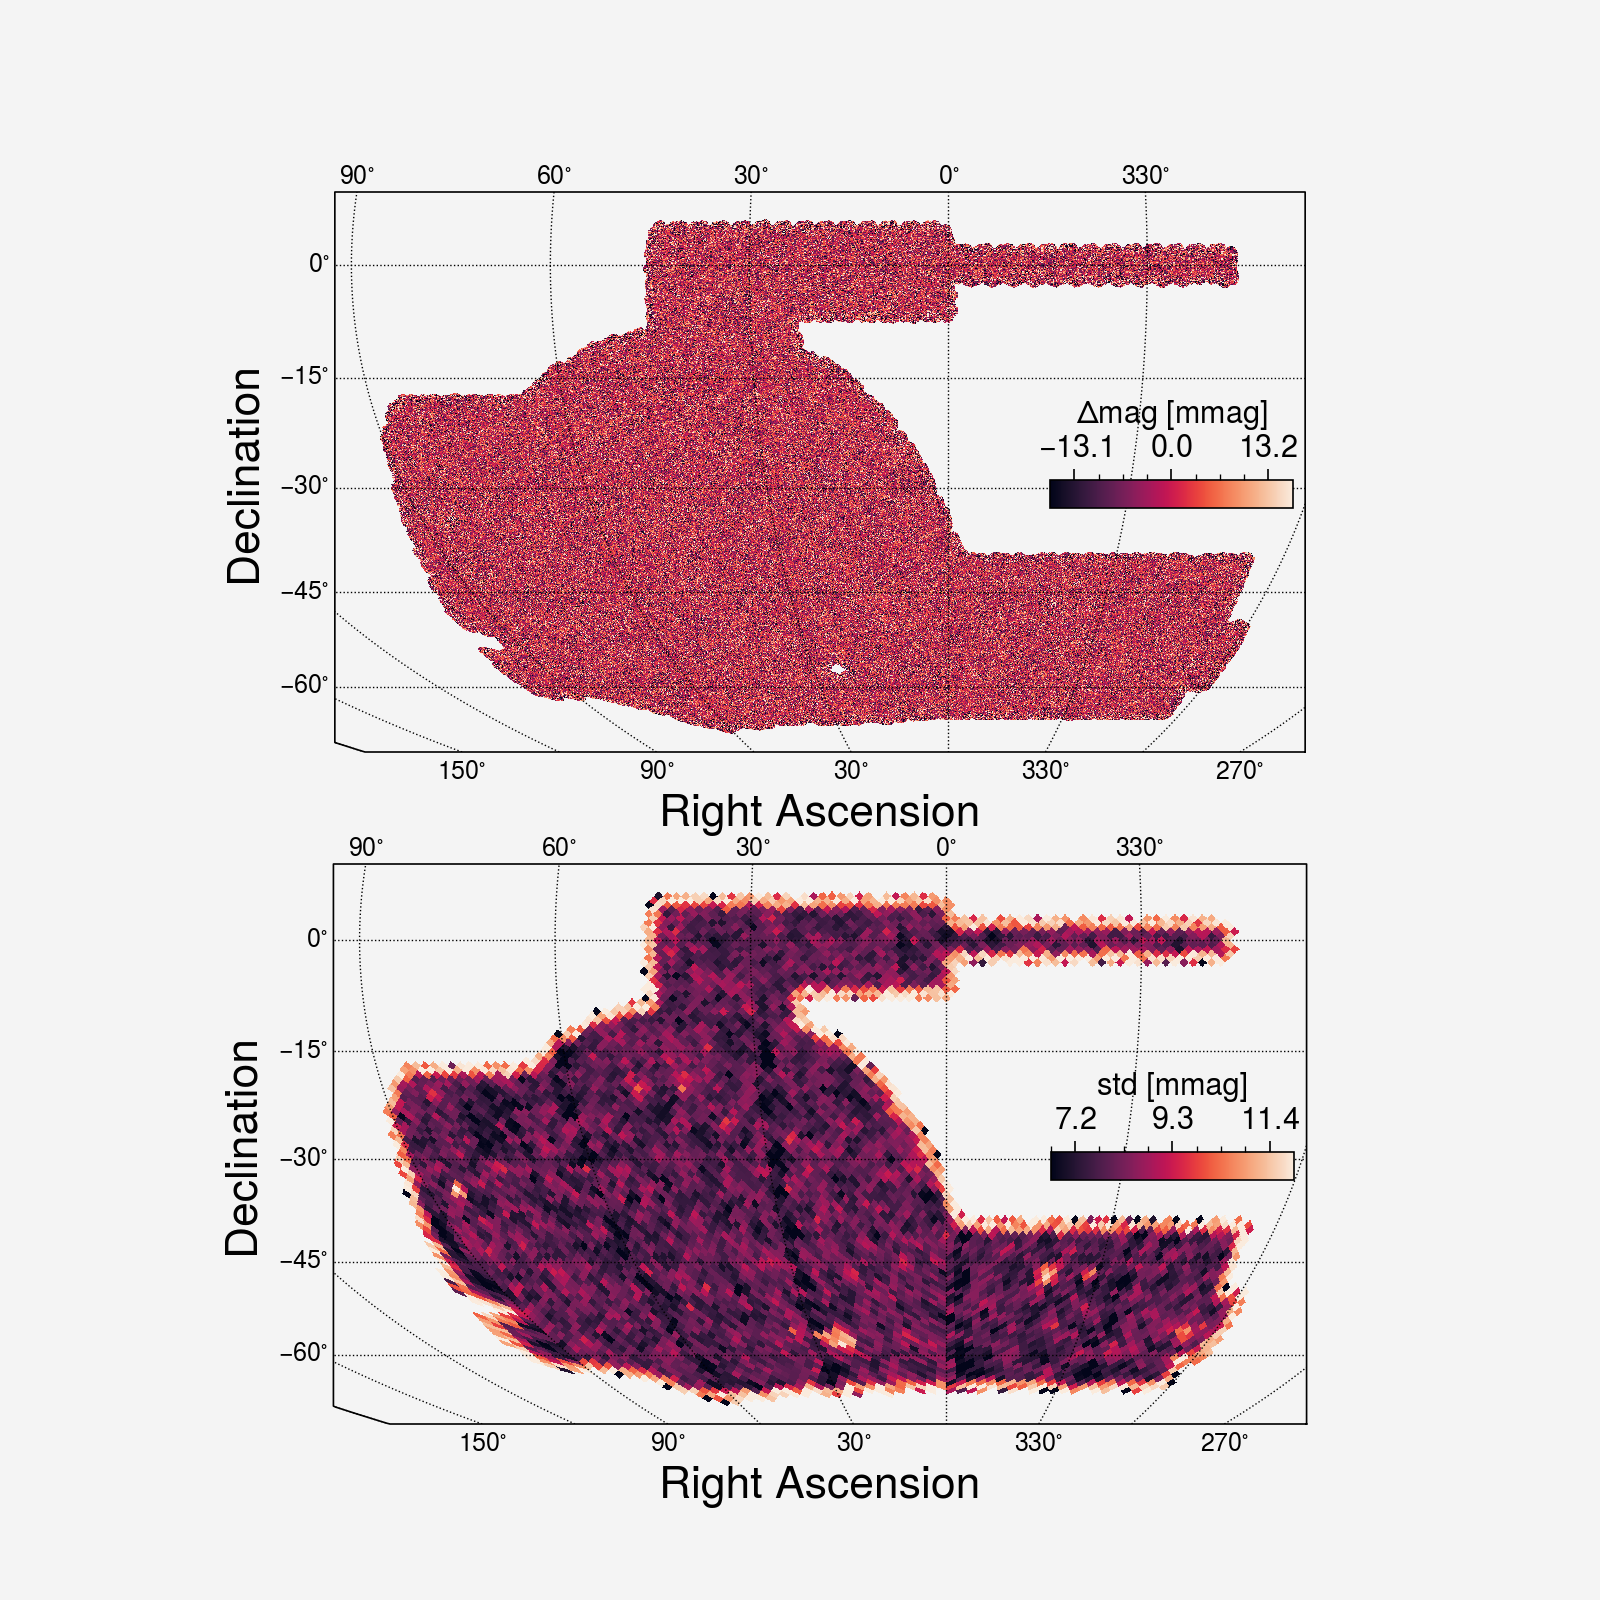

In [631]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8, 8), squeeze=False)

mn_map = hmap.degrade(64, reduction="mean")
sd_map = hmap.degrade(64, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(hmap * 1e3, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

# sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
# sp.draw_hspmap(mn_map/mean_sd, cmap="rocket")
# sp.draw_inset_colorbar(label="mean / std")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map / 1e-3, cmap="rocket")
sp.draw_inset_colorbar(label="std [mmag]")


## straight gd

In [ ]:
alpha = 1e-8
pars = _guess(fd, 1e-5)
for i in range(100000):
    chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)
    pars -= alpha * grad
    if i % 10000 == 0:
        print(i, chi2)

## Try JAX w/ Scipy in Various Ways

In [ ]:
grad

In [ ]:
from functools import partial

@partial(jax.jit, static_argnames=[
    "nnight", 
    "nexp", 
    "nstar", 
    "inv_unight", 
    "istar", 
    "ied", 
    "isstar", 
    "star_obs", 
    "star_obs_err",
])
def _pred_star(
    pars, *, nnight, nexp, nstar, inv_unight, istar, ied, isstar, star_obs, star_obs_err
):
    zp_night = pars[0:nnight]
    zp_exp = pars[nnight:nnight+nexp]
    true_star = pars[nnight+nexp:]
    
    pred_zp = jnp.take(zp_night, jnp.array(list(inv_unight))) + zp_exp
    
    pred_star = jnp.concatenate(
        [
            true_star[jnp.array(list(istar))] 
            + pred_zp[jnp.array(list(ied))],
            true_star[isstar:isstar+1]
        ],
        axis=0,
    )
    return pred_star / jnp.array(list(star_obs_err))

@partial(jax.jit, static_argnames=[
    "nnight", 
    "nexp", 
    "nstar", 
    "inv_unight", 
    "istar", 
    "ied", 
    "isstar", 
    "star_obs", 
    "star_obs_err",
])
def _chi2_pred_star(
    pars, *, nnight, nexp, nstar, inv_unight, istar, ied, isstar, star_obs, star_obs_err
):
    pred_star = _pred_star(
        pars,
        nnight=nnight, 
        nexp=nexp, 
        nstar=nstar, 
        inv_unight=inv_unight, 
        istar=istar, 
        ied=ied, 
        isstar=isstar, 
        star_obs=star_obs, 
        star_obs_err=star_obs_err
    )
    return jnp.sum((jnp.array(list(star_obs)) / jnp.array(list(star_obs_err)) - pred_star)**2)

In [ ]:
data = fd

kwargs = dict(
    nnight=data["data"]["true_zp_night"].shape[0],
    nexp=data["data"]["true_zp_nse"].shape[0],
    nstar=data["data"]["true_star"].shape[0],
    inv_unight=tuple(data["data"]["inv_unight"].tolist()), 
    istar=tuple(data["data"]["istar"].tolist()), 
    ied=tuple(data["data"]["ied"].tolist()), 
    isstar=data["data"]["isstar"], 
    star_obs=tuple(data["data"]["star_obs"].tolist()), 
    star_obs_err=tuple(data["data"]["star_obs_err"].tolist()),
)

In [ ]:
_chi2_pred_star(_guess(fd, 1e-3), **kwargs)

In [ ]:
import jax.scipy.optimize


ofun = partial(_chi2_pred_star, **kwargs)

res = jax.scipy.optimize.minimize(ofun, _guess(fd, 1e-3), method="BFGS", tol=1e-1)

In [ ]:
from scipy.optimize import least_squares

In [ ]:
_chi_pred_star_grad = jax.jit(
    jax.jacobian(_chi_pred_star),
    static_argnames=[
        "nnight", 
        "nexp", 
        "nstar", 
        "inv_unight", 
        "istar", 
        "ied", 
        "isstar", 
        "star_obs", 
        "star_obs_err",
    ]
) 

In [ ]:
res = least_squares(
    _chi_pred_star,
    _guess(fd, 1e-2),
    kwargs=kwargs,
    verbose=2,
    jac=_chi_pred_star_grad,
    method="trf",
)

In [ ]:
res

In [ ]:
fd["data"]["true_zp_night"], fd["data"]["true_zp_nse"], fd["data"]["true_star"]

In [ ]:
res["x"]

In [ ]:
f = np.ones(10)

In [ ]:
jax.jacobian(_pred_star)(_guess(fd, 1e-3), **kwargs)

In [491]:
numba.njit?